# 02 Neural Network Classification

Classification is a problem of predicting whether something is one thing or another.  There can be multiple options.

In [1]:
## 1. Make classification data and get it ready

In [2]:
import sklearn
from sklearn.datasets import make_circles

In [3]:
# Make 1000 Samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [6]:
print(y[:5])

[1 1 1 1 0]


In [7]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


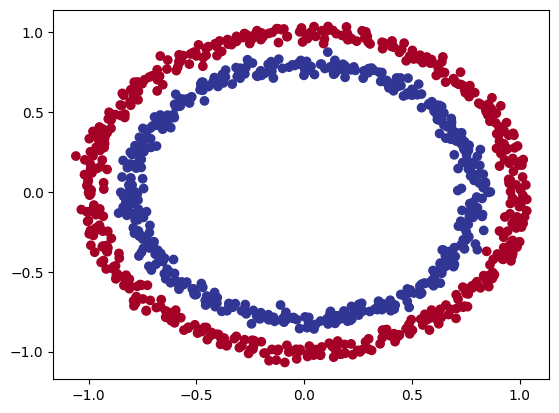

In [8]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(circles['X1'], circles['X2'], c=circles['label'], cmap=plt.cm.RdYlBu)

### 1 Check input and output shapes

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
type(X)

numpy.ndarray

In [11]:
# View the firs example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values of one sample of X: {X_sample}")
print(f"Value of one sample of y: {y_sample}")

Values of one sample of X: [0.75424625 0.23148074]
Value of one sample of y: 1


### 2 Turn data into tensors, and split into train test splits

In [12]:
# Turn data into tensors of type float 32, since numpy defaults to float64
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Spit data into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 3 Building a model

Build a model to classify the blue and red dots.
To do so, we want to:
1. Set up device agnostic code
2. Construct a model by subclassing nn.Module
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [17]:
# Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create nn.Linear layers to handle the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # Define the forward method
  def forward(x: torch.tensor) -> torch.tensor:
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)

In [18]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.0832,  0.4560],
        [ 0.1882,  0.6523],
        [-0.0980,  0.3923],
        [-0.2221, -0.6622],
        [-0.0154, -0.0436]], requires_grad=True)

In [19]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}")
print(f"Shape of predictions: {untrained_preds.shape}")
print(f"First 10 predictions: {untrained_preds[:10]}")
print(f"First 10 labels: {y_test[:10]}")

Length of predictions: 200
Shape of predictions: torch.Size([200, 1])
First 10 predictions: tensor([[0.5082],
        [0.4990],
        [0.5315],
        [0.5016],
        [0.5301],
        [0.5244],
        [0.4996],
        [0.5056],
        [0.5315],
        [0.4984]], grad_fn=<SliceBackward0>)
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 3.1 Setup loss function and optimizer

Which loss function or optimizer should you use? This is problem specific
For binary, you want binary cross-entropy

And for optimizers, two of the most common are SGD and Adam

In [21]:
# Set up the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Set up the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=.01)

In [22]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### 3.2 Train a model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Backward pass
5. Optimizer step

### 3.3 Going from raw logits -> prediction probabilities -> prediction labels

The model is going to output raw **logits**

We can convert them into prediction probabilities by passing them to an activation functions, then convert the probabilities to prediction labels

In [23]:
# View the first 5 outputs of the the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5082],
        [0.4990],
        [0.5315],
        [0.5016],
        [0.5301]])

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6244],
        [0.6222],
        [0.6298],
        [0.6228],
        [0.6295]])

In [26]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.4 Building a Training and Test loop

In [29]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits into pred labels

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropogation
  loss.backward()

  # Gradient Descent
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out the results
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72660 | Acc: 50.00% | Test loss: 0.72542 | Test acc: 50.00%
Epoch: 10 | Loss: 0.72358 | Acc: 50.00% | Test loss: 0.72241 | Test acc: 50.00%
Epoch: 20 | Loss: 0.72083 | Acc: 50.00% | Test loss: 0.71967 | Test acc: 50.00%
Epoch: 30 | Loss: 0.71832 | Acc: 50.00% | Test loss: 0.71719 | Test acc: 50.00%
Epoch: 40 | Loss: 0.71605 | Acc: 50.00% | Test loss: 0.71493 | Test acc: 50.00%
Epoch: 50 | Loss: 0.71398 | Acc: 50.00% | Test loss: 0.71288 | Test acc: 50.00%
Epoch: 60 | Loss: 0.71210 | Acc: 50.00% | Test loss: 0.71102 | Test acc: 50.00%
Epoch: 70 | Loss: 0.71040 | Acc: 50.00% | Test loss: 0.70932 | Test acc: 50.00%
Epoch: 80 | Loss: 0.70884 | Acc: 50.00% | Test loss: 0.70778 | Test acc: 50.00%
Epoch: 90 | Loss: 0.70743 | Acc: 50.00% | Test loss: 0.70639 | Test acc: 50.00%
Epoch: 100 | Loss: 0.70614 | Acc: 50.00% | Test loss: 0.70512 | Test acc: 50.00%
Epoch: 110 | Loss: 0.70498 | Acc: 50.00% | Test loss: 0.70396 | Test acc: 50.00%
Epoch: 120 | Loss: 0.70392 | Acc: 50.00

## 4 Make predictions and evaluate the model

From the metrics, the model is performing poorly.  To inspect it, we'll visualize some predictions.

In [30]:
import requests
from pathlib import Path

# Download helper functions from learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper functions already exist!")
else:
  print("Downloading helper functions...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


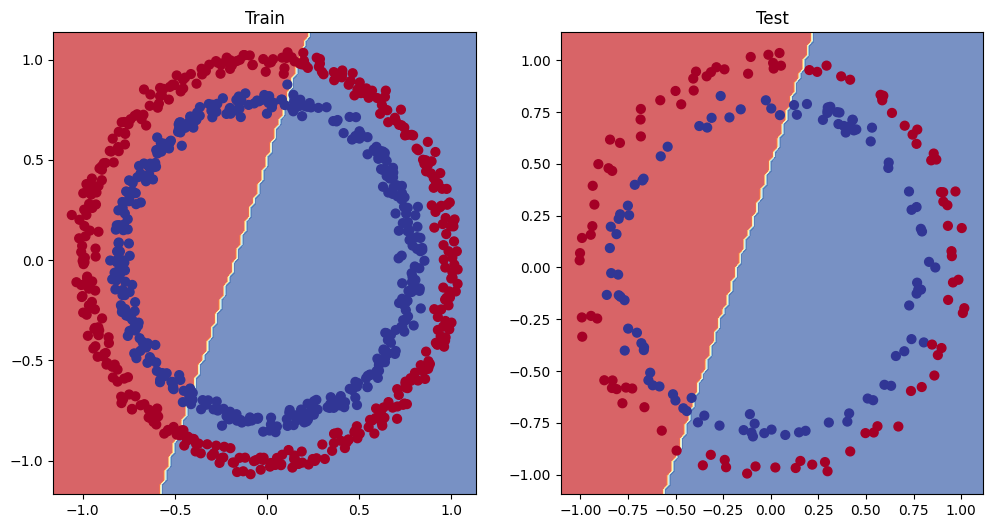

In [31]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5 Improving a model

* Add more layers - give the model more chances to learn
* Add more hidden units - go from 5 hidden units to 10
* Change the activation function
* Change the learning rate
* Change the loss function

Let's improve the model by adding more hidden units, layers, and epochs

In [32]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=.01)

In [34]:
# Create a training and testing loop
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train.to(device)).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train.to(device))
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test.to(device)).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test.to(device))
    test_acc = accuracy_fn(y_true=y_test.to(device),
                           y_pred=test_pred)

  if epoch % 10  == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test acc: 51.00%
Epoch: 10 | Loss: 0.69392 | Acc: 50.50% | Test loss: 0.69262 | Test acc: 51.00%
Epoch: 20 | Loss: 0.69389 | Acc: 50.62% | Test loss: 0.69262 | Test acc: 50.50%
Epoch: 30 | Loss: 0.69386 | Acc: 50.62% | Test loss: 0.69263 | Test acc: 50.50%
Epoch: 40 | Loss: 0.69383 | Acc: 50.62% | Test loss: 0.69264 | Test acc: 50.50%
Epoch: 50 | Loss: 0.69381 | Acc: 50.75% | Test loss: 0.69264 | Test acc: 50.50%
Epoch: 60 | Loss: 0.69378 | Acc: 50.62% | Test loss: 0.69265 | Test acc: 51.00%
Epoch: 70 | Loss: 0.69376 | Acc: 50.25% | Test loss: 0.69266 | Test acc: 51.00%
Epoch: 80 | Loss: 0.69373 | Acc: 50.00% | Test loss: 0.69267 | Test acc: 50.50%
Epoch: 90 | Loss: 0.69371 | Acc: 49.88% | Test loss: 0.69268 | Test acc: 50.50%
Epoch: 100 | Loss: 0.69369 | Acc: 50.25% | Test loss: 0.69269 | Test acc: 50.00%
Epoch: 110 | Loss: 0.69367 | Acc: 50.25% | Test loss: 0.69270 | Test acc: 50.00%
Epoch: 120 | Loss: 0.69365 | Acc: 50.38

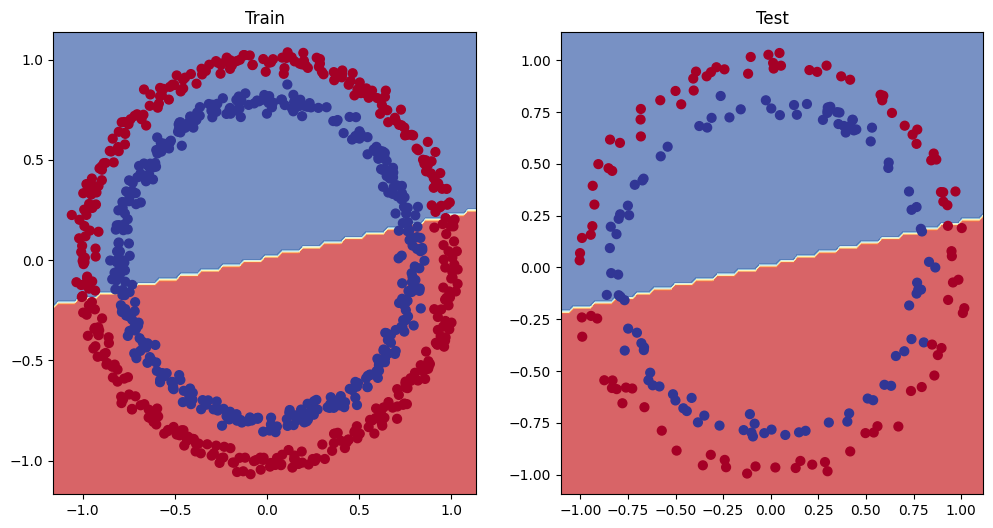

In [35]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


## 6 The missing piece: non-linearity

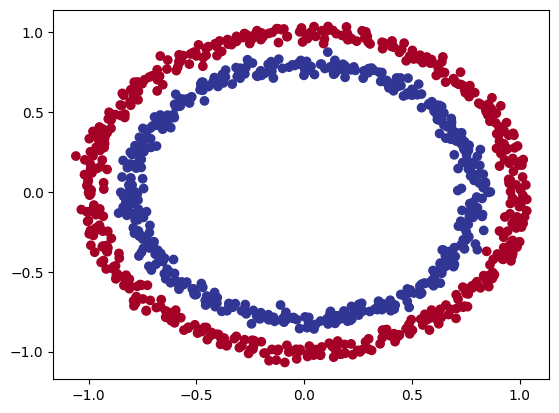

In [36]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [37]:
# Convert to tensors, and train/test splits

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.1 Building a model with non-linearity

In [38]:
# Build a model with non-linear activations

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [40]:
epochs = 2000
epoch_count = []
loss_values = []
test_loss_values = []

# Put data to the target device
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc}")
    epoch_count.append(epoch)
    loss_values.append(loss.cpu().detach().numpy())
    test_loss_values.append(test_loss.cpu().detach().numpy())

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test loss: 0.69319 | Test acc: 50.0
Epoch: 10 | Loss: 0.69248 | Acc: 50.50% | Test loss: 0.69260 | Test acc: 50.0
Epoch: 20 | Loss: 0.69225 | Acc: 59.13% | Test loss: 0.69231 | Test acc: 56.49999999999999
Epoch: 30 | Loss: 0.69209 | Acc: 70.25% | Test loss: 0.69212 | Test acc: 68.0
Epoch: 40 | Loss: 0.69195 | Acc: 68.38% | Test loss: 0.69195 | Test acc: 71.0
Epoch: 50 | Loss: 0.69181 | Acc: 58.25% | Test loss: 0.69177 | Test acc: 57.99999999999999
Epoch: 60 | Loss: 0.69168 | Acc: 54.00% | Test loss: 0.69161 | Test acc: 54.50000000000001
Epoch: 70 | Loss: 0.69155 | Acc: 53.12% | Test loss: 0.69146 | Test acc: 53.0
Epoch: 80 | Loss: 0.69141 | Acc: 52.62% | Test loss: 0.69132 | Test acc: 53.0
Epoch: 90 | Loss: 0.69128 | Acc: 52.75% | Test loss: 0.69117 | Test acc: 53.0
Epoch: 100 | Loss: 0.69115 | Acc: 52.88% | Test loss: 0.69102 | Test acc: 52.5
Epoch: 110 | Loss: 0.69103 | Acc: 52.88% | Test loss: 0.69088 | Test acc: 53.5
Epoch: 120 | Loss: 0.690

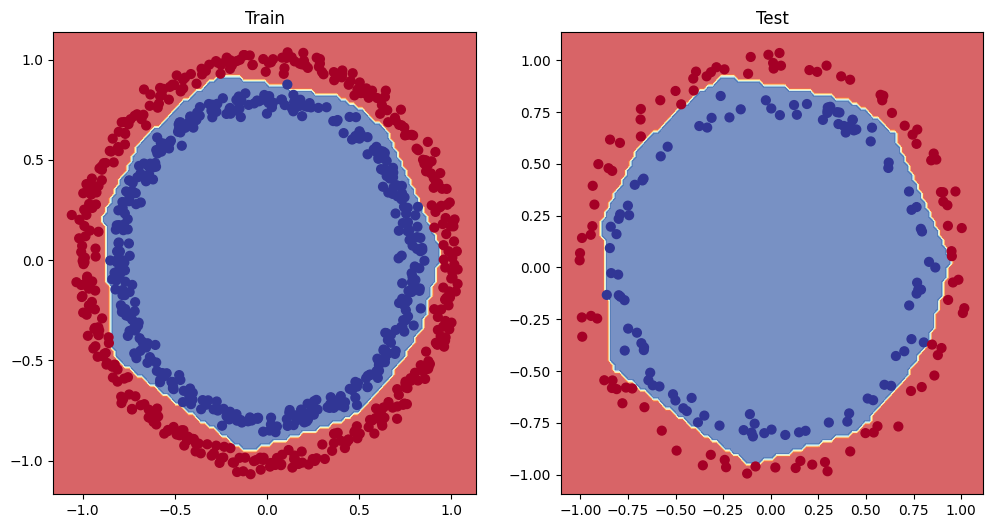

In [41]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


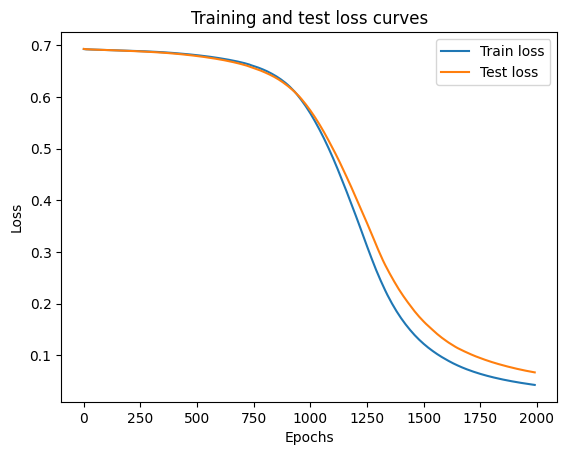

In [42]:
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

## Multi-class Classification

### Creating a toy multi-class dataset

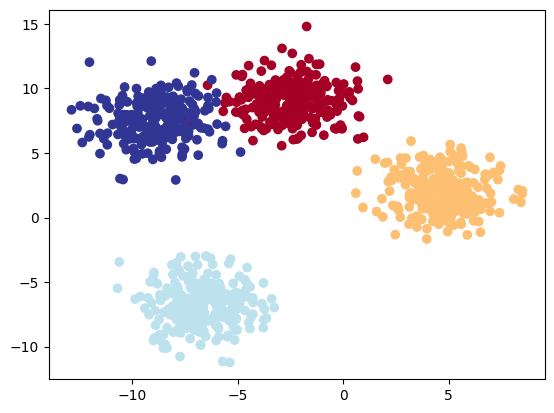

In [53]:
from sklearn.datasets import make_blobs

# Set the hyperparamers for dataset creation
NUM_ClASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_ClASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Create a scatter plot of the data
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [54]:
# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=.2,
                                                                        random_state=RANDOM_SEED)

### Building a multi-class classification model

In [55]:
# Build a multi-class classification mode

class BlobModel(nn.Module):
  def __init__(self, input_features: int,
               output_features: int,
               hidden_units: int=8):
    """ Initializes a multi-class classification model

    Args:
      input_features (int): Number of input features
      output_features (int): Number of output features
      hidden_units (int, optional): Number of hidden units. Defaults to 8.
    """
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.linear_layer_stack(x)

# Create an instance of Blob and send it to the target device
model_4 = BlobModel(2, 4, 8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Create a loss function and an optimizer

In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### Getting prediction probabilities for muli-class model

In order to evaluate, train, and test our model, we need to convert the logits to prediction probabilities and then to prediction labels.

In [57]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [58]:
# Convert the logit outputs to prediction probability
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [59]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [60]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### Creating a training and testing loop for a multi-class PyTorch model

In [61]:
epoch_count = []
loss_values = []
test_loss_values = []

# Fit the model to the data
torch.manual_seed(42)

epochs = 100

# put the data on the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  model_4.train()

  # Forward Pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calculate the loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # Zero Grad
  optimizer.zero_grad()

  # Backpropogation
  loss.backward()

  # Optimizer step
  optimizer.step()

  #Testing code
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)

  print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
  epoch_count.append(epoch)
  loss_values.append(loss.cpu().detach().numpy())
  test_loss_values.append(test_loss.cpu().detach().numpy())


Epoch: 0 | Loss: 1.15883 | Acc: 40.38% | Test loss: 1.07554 | Test acc: 48.00%
Epoch: 1 | Loss: 1.06362 | Acc: 54.62% | Test loss: 1.00386 | Test acc: 55.00%
Epoch: 2 | Loss: 0.98013 | Acc: 61.38% | Test loss: 0.94132 | Test acc: 64.00%
Epoch: 3 | Loss: 0.90937 | Acc: 67.62% | Test loss: 0.88772 | Test acc: 74.50%
Epoch: 4 | Loss: 0.85076 | Acc: 76.75% | Test loss: 0.84193 | Test acc: 90.50%
Epoch: 5 | Loss: 0.80226 | Acc: 91.12% | Test loss: 0.80272 | Test acc: 94.00%
Epoch: 6 | Loss: 0.76171 | Acc: 93.38% | Test loss: 0.76864 | Test acc: 95.00%
Epoch: 7 | Loss: 0.72714 | Acc: 94.50% | Test loss: 0.73842 | Test acc: 95.00%
Epoch: 8 | Loss: 0.69697 | Acc: 95.38% | Test loss: 0.71099 | Test acc: 96.00%
Epoch: 9 | Loss: 0.66986 | Acc: 96.38% | Test loss: 0.68530 | Test acc: 97.00%
Epoch: 10 | Loss: 0.64476 | Acc: 96.75% | Test loss: 0.66069 | Test acc: 97.50%
Epoch: 11 | Loss: 0.62096 | Acc: 97.25% | Test loss: 0.63668 | Test acc: 98.00%
Epoch: 12 | Loss: 0.59793 | Acc: 97.75% | Test los

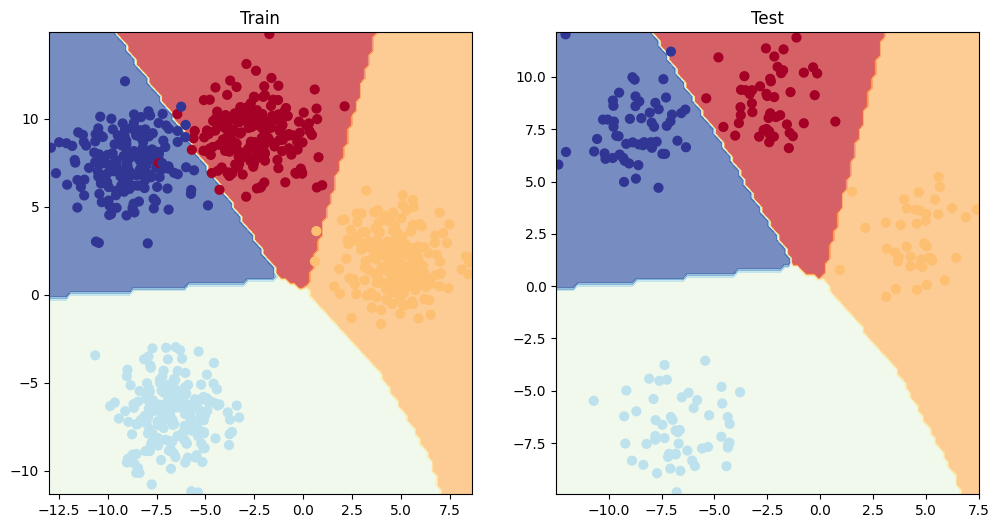

In [62]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


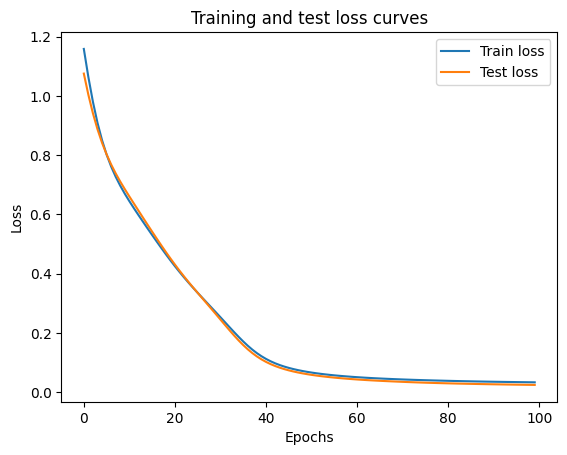

In [63]:
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

## A few more classification metrics to evaluate our model

* Accuracy - out of 100 samples how many does our model get right
* Precision
* Recall
* F1 Score
* Confusion Matrix
* Classification report

[Beyond Accuracy Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

In [64]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 19.0 MB/s eta 0:00:00


In [68]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4)
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.3550)